# DDA 4230 Tutorial 10

## Section 0:  Outline
1. Overview of RL Algorithms
2. DQN


In [1]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

## Section 1: Overview of RL Algorithms
<img src="https://i.loli.net/2021/04/19/PAG6mKN2ckL9Yx8.jpg" style="width: 800px;" center/>
<h3 style="text-align:center">Classification of RL ALgorithms from A.T.D.Perera </h3>
Up to now, we have learned:

### Tabular Methods:
* Value Iteration
* Policy Iteration
* Q-learning
* SARSA
* TD($\lambda$)

### Approximation Methods:
* REINFORCE 
* REINFORCE with Baselines
* Actor Critic
* DQN


## Section 2: DQN

### CartPole
Consider the CartPole problem.  A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of $+1$ or $-1$ to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of $+1$ is provided for every timestep that the pole remains upright. The episode ends when the pole is more than $15$ degrees from vertical, or the cart moves more than $2.4$ units from the center. The state space is continuous and each state is a tuple of cart position, cart velocity, pole angle, and pole angular velocity. There are 2 discrete deterministic actions: Left and Right.

Note: CartPole-v0 defines "solving" as getting average undiscounted return of 195.0 over 100 consecutive trials
		

### DQN
Q-Learning is an off-policy algorithm that learns about the greedy policy $a = \max_{a} Q(s, a; \theta)$ while using a different behaviour policy for acting in the environment/collecting data. This behaviour policy is usually an $\epsilon$-greedy policy that selects the greedy action with probability $1-\epsilon$ and a random action with probability $\epsilon$ to ensure good coverage of the state-action space.


To avoid computing the full expectation in the DQN loss, we can minimize it using stochastic gradient descent. If the loss is computed using just the last transition ${s, a, r, s'}$, this reduces to standard Q-Learning.


<img src="https://i.loli.net/2021/04/19/3tdZj5Wbu7A2avO.png" style="width: 800px;" center/>

In [2]:
class Net(nn.Module):
    # A Simple Q Network
    def __init__(self, dim_state, n_action):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(dim_state, 128)
        self.fc2 = nn.Linear(128, n_action)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        action_value = self.fc2(x)
        return action_value

In [3]:
class DQN():

    def __init__(self, capacity, learning_rate, batch_size, gamma, dim_state, n_action):
        super(DQN, self).__init__()
        self.capacity = capacity
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.gamma = gamma
        self.n_action = n_action
        self.dim_state = dim_state

        self.target_net, self.act_net = Net(
            dim_state, n_action), Net(dim_state, n_action)
        self.memory = [None]*self.capacity
        self.optimizer = optim.Adam(
            self.act_net.parameters(), self.learning_rate)
        self.loss_func = nn.MSELoss()

        self.memory_count = 0
        self.update_count = 0

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        value = self.act_net(state)
        action_max_value, index = torch.max(value, 1)
        action = index.item()
        if np.random.rand(1) >= 0.9:  # epslion greedy
            action = np.random.choice(range(self.n_action), 1).item()
        return action

    def store_transition(self, transition):
        index = self.memory_count % self.capacity
        self.memory[index] = transition
        self.memory_count += 1
        return self.memory_count >= self.capacity

    def update(self):
        if self.memory_count >= self.capacity:
            state = torch.tensor([t.state for t in self.memory]).float()
            action = torch.LongTensor(
                [t.action for t in self.memory]).view(-1, 1).long()
            reward = torch.tensor([t.reward for t in self.memory]).float()
            next_state = torch.tensor(
                [t.next_state for t in self.memory]).float()
            done = torch.tensor(
                [t.done for t in self.memory]).float()

            #reward = (reward - reward.mean()) / (reward.std() + 1e-7)
            with torch.no_grad():
                target_v = reward + (1-done)*self.gamma * \
                    self.target_net(next_state).max(1)[0]

            # Update...
            for index in BatchSampler(SubsetRandomSampler(range(len(self.memory))), batch_size=self.batch_size, drop_last=False):
                v = (self.act_net(state).gather(1, action))[index]
                loss = self.loss_func(target_v[index].unsqueeze(
                    1), (self.act_net(state).gather(1, action))[index])
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.update_count += 1
                if self.update_count % 100 == 0:
                    self.target_net.load_state_dict(self.act_net.state_dict())
        else:
            pass

100%|██████████| 1000/1000 [10:16<00:00,  1.62it/s]


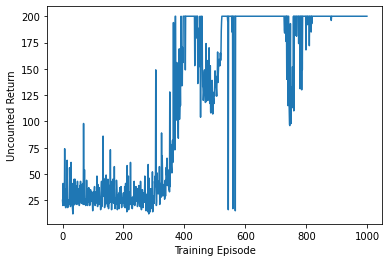

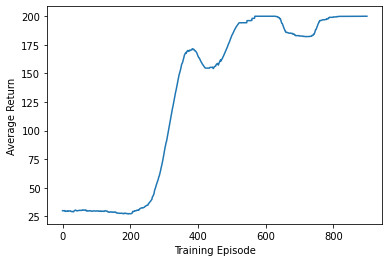

In [5]:
# Hyper-parameters
seed = 1
num_episodes = 1000
env = gym.make('CartPole-v0')
n_action = env.action_space.n
dim_state = env.observation_space.shape[0]

torch.manual_seed(seed)
env.seed(seed)

# Replay Buffer
Transition = namedtuple(
    'Transition', ['state', 'action', 'reward', 'next_state', 'done'])

capacity = 8000
learning_rate = 1e-3
batch_size = 256
gamma = 0.995

agent = DQN(capacity=capacity, learning_rate=learning_rate,
            batch_size=batch_size, gamma=gamma, dim_state=dim_state, n_action=n_action)
return_list = []  

for i_ep in tqdm(range(num_episodes)):
    state = env.reset()
    total_return = 0
    for t in range(200):
        # Choose Action
        action = agent.select_action(state)
        
        # Step in Env
        next_state, reward, done, info = env.step(action)
        total_return += reward
        
        # Add transition to Buffer
        transition = Transition(state, action, reward, next_state, float(done))
        agent.store_transition(transition)
        state = next_state
        
        if done or t >= 199:
            # To facilitate our training, update per episode.
            agent.update()
            break
    return_list.append(total_return)
plt.plot(return_list)
plt.xlabel('Training Episode')
plt.ylabel('Uncounted Return')
plt.savefig('CartPole_DQN.png')
plt.show()
plt.close()
moving_average = [np.mean(return_list[i:(i+100)])
                  for i in range(num_episodes-100)]
plt.plot(moving_average)
plt.xlabel('Training Episode')
plt.ylabel('Average Return')
plt.savefig('CartPole_DQN_Average.png')
plt.show()
plt.close()